In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [10]:
tau = ['3', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/Extra/AC14restoring/'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'dayflat/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

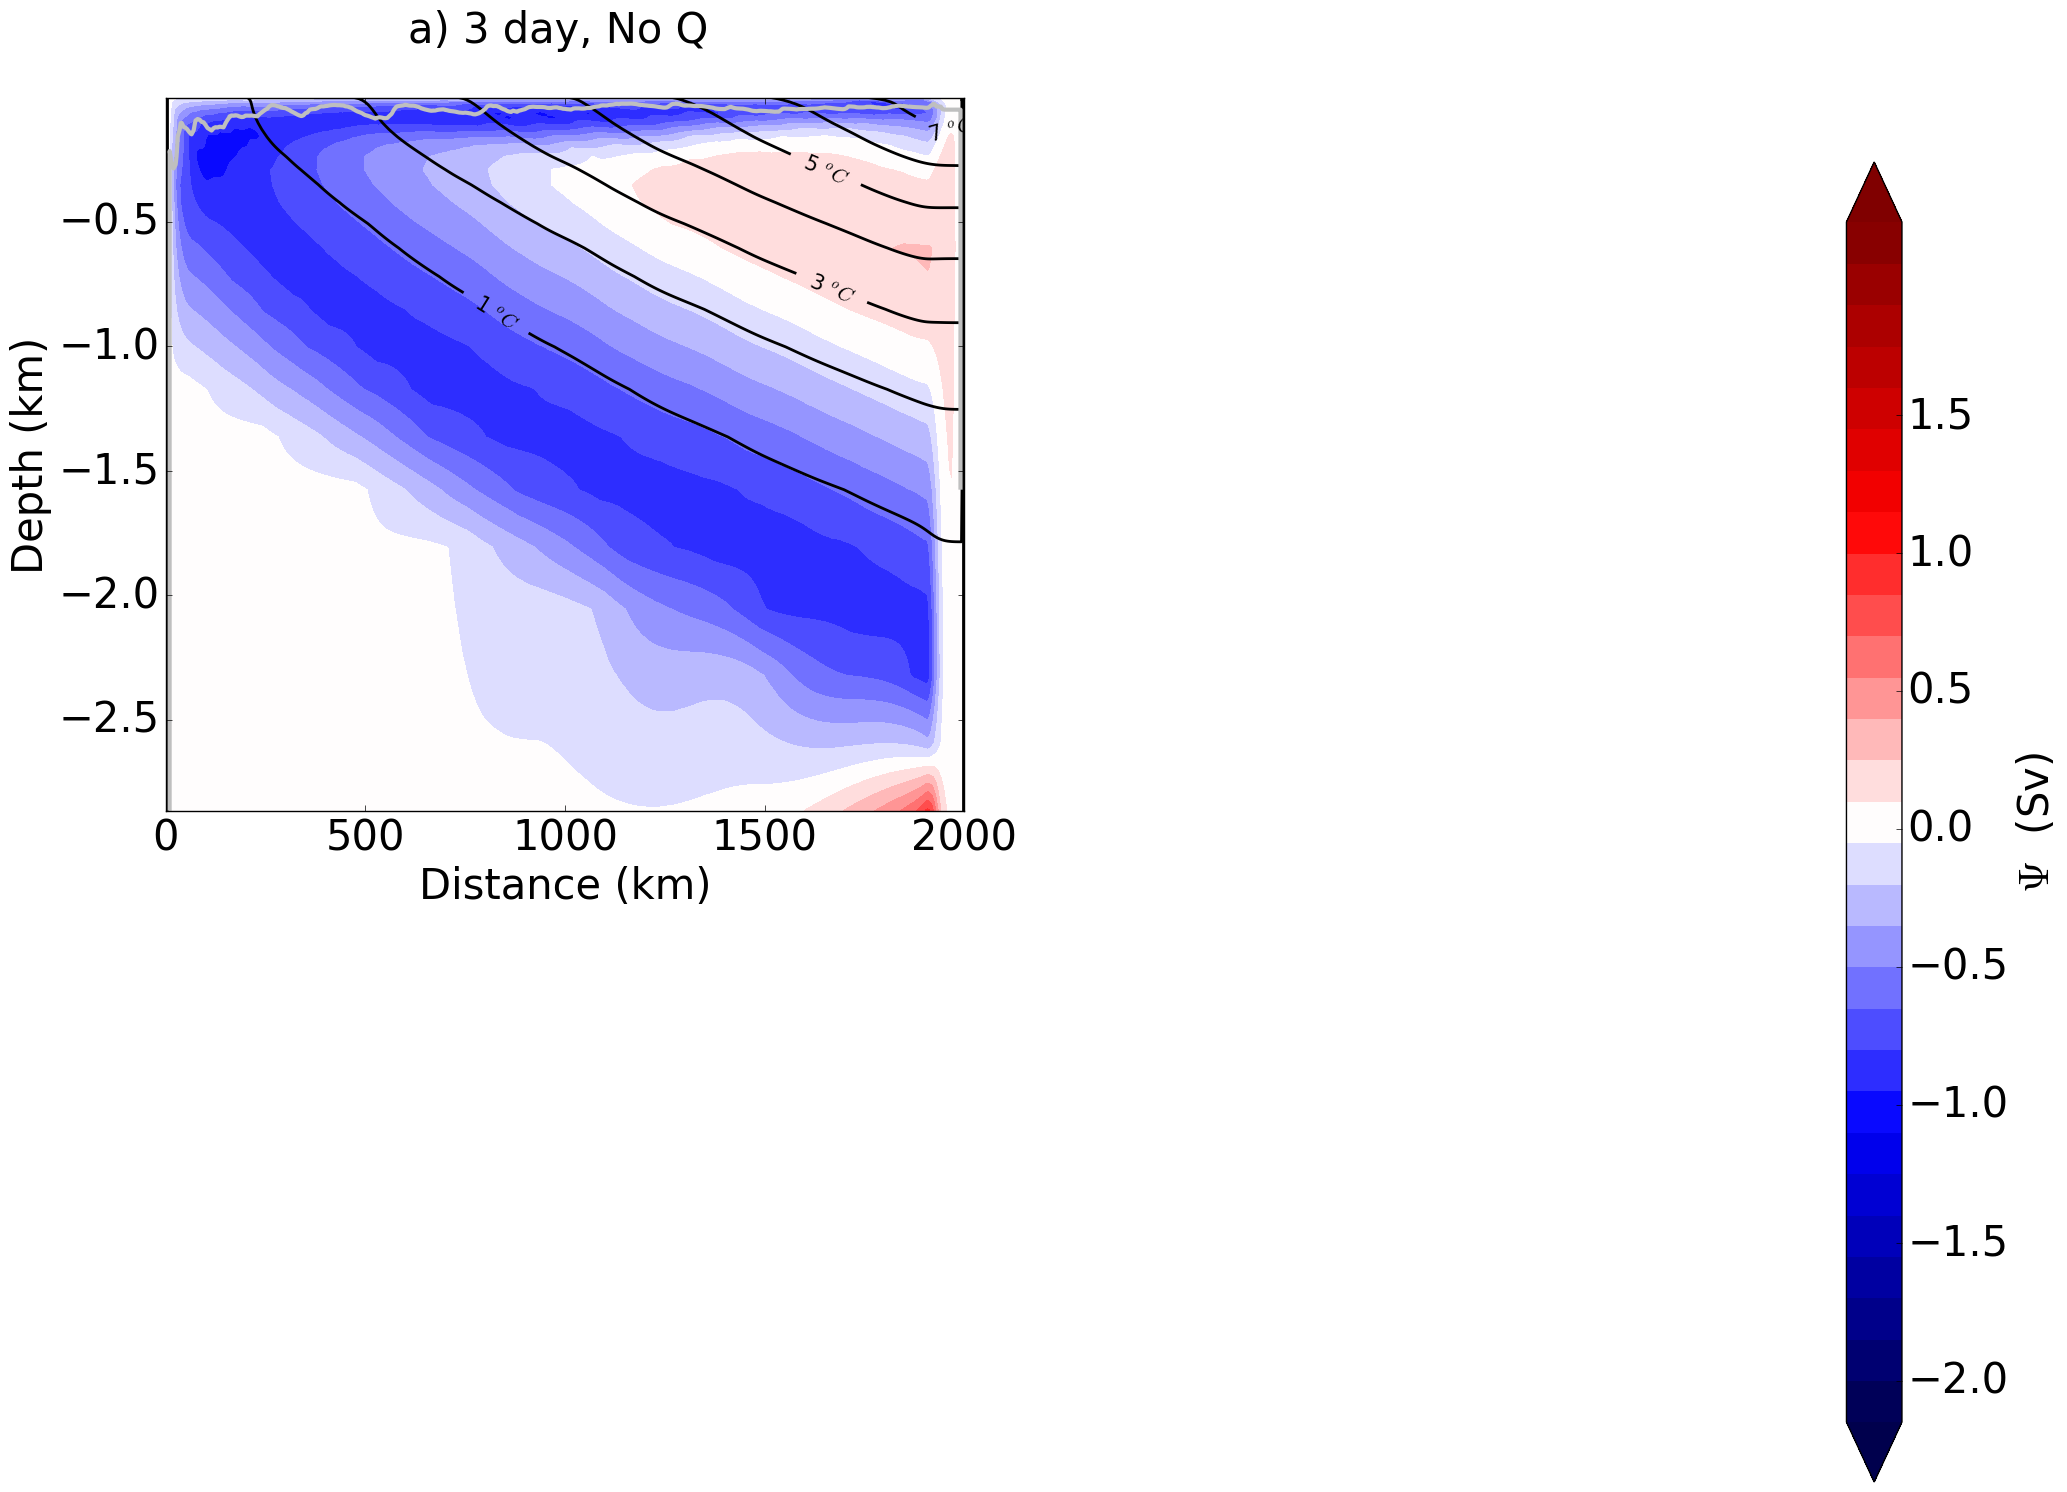

In [11]:
fig = plt.figure(figsize=(18.5, 16.5))
# Create Panels
Psi_levs = np.arange(-2.2, 2.25, .15)+0.05
Psi_ticks =np.arange(-2., 2., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = arange(-1,8,1),arange(-1,8,1),arange(-1,8,1)
layer_start = []
layer_fin = []
layer_med = []
for i in range(len(Runs)):
    #i =2 
    fname = x+'/'+str(tau[Runs[i]])+'dayflat/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS

    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc_numba.LayersComputer(c)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    PIz[-5::,50::]=np.nan
    ax = fig.add_subplot(2, 2, i+1)
    # Make list of ROC / ROC0
    layer_start.append(c.get_zonal_avg('Tav.nc', 'THETA').min())
    layer_fin.append(c.get_zonal_avg('Tav.nc', 'THETA').max())
    layer_med.append(c.get_zonal_avg('Tav.nc', 'THETA').mean())
    p = ax.contourf(c.yc/1000, c.zc/1000,
                Psi, Psi_levs, cmap=plt.cm.seismic, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    r = ax.contour(c.yg/1000,c.zc/1000, PIz,[0.999], colors='0.75', linewidths=3)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day, restoring \n', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

In [12]:
# Generate layers
# Select run
i = 0
# Tell me the run I've selected
print tau[i],'m'
# Parameters from output adjust to ensure all layers are fully captured
bot = math.floor(layer_start[i]) # Round down
top = math.ceil(layer_fin[i]) # Round up
med = np.round(np.round(layer_med[i],1))
# High resolution for the layers of interest!
layers = np.arange(med-1.0,med+1.0, 0.1)
# Fill in the layers from low temps to layers of interest
layers1 = np.linspace(bot,layers[0],12)
# Fill in the layers from layers of interest to the maximum temperature
layers2 = np.linspace(layers[-1],top,12)
# Concatonate 
layers_data = layers1[0:-1].tolist() + layers.tolist() + layers2[1::].tolist()
layers_data.append(top+0.2)
# Adjust for temperature skews
# If layers of interest encompass the bottom value
if med-1 <= bot: 
    # Fill in only the layers of interest to the maximum temperature
    layers2 = np.linspace(layers[-1],top,23)
    layers_data = layers.tolist() + layers2[1::].tolist() 
    layers_data.append(top+0.2)
# If layers of interest are far hotter than the bottom value
elif abs(bot-(med-1))<2.4 :
    # Take less lower values
    layers1 = np.linspace(bot,layers[0],10)
    # And more higher values
    layers2 = np.linspace(layers[-1],top,14)
    layers_data = layers1[0:-1].tolist() + layers.tolist() + layers2[1::].tolist() 
# Neaten it up
layers_data_final = np.round(layers_data,2)
layers_data.append(top+0.2)
# Commma separate it.
print ",".join(map(str,layers_data_final))

3 m
0.0,0.11,0.22,0.33,0.44,0.56,0.67,0.78,0.89,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.29,3.68,4.08,4.47,4.86,5.25,5.65,6.04,6.43,6.82,7.22,7.61,8.0
